Данный ноутбук показывает умение проектировать A/B-тесты, улучшать их чувствительность, анализировать результаты.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm

Данные взяты с другого выполненного мной проекта, посвященного анализу данных в ритейле. Сюжет состоит в том, что мы вносим некоторое изменение в экспериментальную группу клиентов, которые были активны во временной отрезок 0 (то есть потратили более 0 рублей). Затем следует временной промежуток 1 (равный 1 неделе), на котором вносится некоторое изменение, ожидается эффект равный 100 рублям. Задача тестирования заключается в том, чтобы уловить данный эффект.

In [2]:
data = pd.read_csv('purchases_processed.csv', usecols=['client_id', 'transaction_datetime', 'sum_purchase'])

In [3]:
data.transaction_datetime = pd.to_datetime(data.transaction_datetime)

In [4]:
data.head()

,client_id,transaction_datetime,sum_purchase
0,000012768d,2019-03-08,804
1,000012768d,2018-12-01,1007
2,000012768d,2019-03-14,419
3,000012768d,2018-12-16,575
4,000036f903,2018-12-21,700


In [6]:
time = data.transaction_datetime.unique()

In [7]:
dataframes = []

In [8]:
for start in tqdm(time):
    t0 = data[(data.transaction_datetime >= start) & (data.transaction_datetime <= start+pd.Timedelta(days=6))]
    t0 = t0.groupby('client_id').sum_purchase.sum().reset_index()
    t1 = data[(data.transaction_datetime >= start+pd.Timedelta(days=7)) & (data.transaction_datetime <= start+pd.Timedelta(days=13))]
    t1 = t1.groupby('client_id').sum_purchase.sum().reset_index()


    df = pd.merge(t0, t1, on='client_id', how='left', suffixes=['_0', '_1']).fillna(0)
    dataframes.append(df)

100%|██████████| 118/118 [01:35<00:00,  1.23it/s]


In [46]:
length = np.arange(len(dataframes))
aa_test = []
ab_test = []
first_type_error = []
SAMPLE_SIZE = 400
EFFECT_SIZE = 100

for i in tqdm(range(2000)):
    df = dataframes[np.random.choice(length, size=1)[0]]

    control = df.sample(SAMPLE_SIZE * 2)
    
    experiment = control.iloc[:SAMPLE_SIZE, :]
    control = control.iloc[SAMPLE_SIZE:, :]
    control['treatment'] = 0
    experiment['treatment'] = 1
    df = pd.concat((control, experiment), axis=0)

    df['purchase_diff'] = df['sum_purchase_1'] - df['sum_purchase_0']

    control_group = df[df['treatment'] == 0]['purchase_diff']
    treatment_group = df[df['treatment'] == 1]['purchase_diff']

    pval = stats.ttest_ind(treatment_group, control_group, equal_var=False).pvalue

    aa_test.append(pval)
    if pval < 0.05:
        first_type_error.append(1)
    else:
        first_type_error.append(0)

    pval = stats.ttest_ind(treatment_group+EFFECT_SIZE, control_group, equal_var=False).pvalue
    ab_test.append(pval)

ab_test = np.array(ab_test)

100%|██████████| 2000/2000 [00:28<00:00, 69.22it/s]


In [47]:
print('Ошибка первого рода:', round(np.array(first_type_error).mean(), 2))
print('Мощность критерия на 5-процентном уровне значимости:', np.round(ab_test[ab_test <= 0.05].shape[0] / ab_test.shape[0], 2))

Ошибка первого рода: 0.05
Мощность критерия на 5-процентном уровне значимости: 0.32


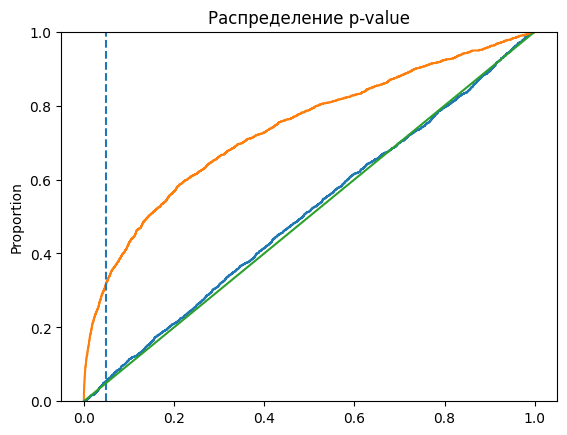

In [48]:
x = np.linspace(0, 1, 100)
sns.ecdfplot(aa_test)
sns.ecdfplot(ab_test)
plt.vlines(x=0.05, ymin=0, ymax=1, linestyles='--')
plt.plot(x, x)
plt.title('Распределение p-value')
plt.show()

Мы видим, что тест не показывает чувствительности. Попробуем улучшить ее с помощью CUPED.

In [50]:
cuped_aa_test = []
cuped_ab_test = []
cuped_first_type_error = []
SAMPLE_SIZE = 400
EFFECT_SIZE = 100

for i in tqdm(range(2000)):
    df = dataframes[np.random.choice(length, size=1)[0]]

    control = df.sample(SAMPLE_SIZE * 2)
    
    experiment = control.iloc[:SAMPLE_SIZE, :]
    control = control.iloc[SAMPLE_SIZE:, :]
    control['treatment'] = 0
    experiment['treatment'] = 1
    df = pd.concat((control, experiment), axis=0)
    
    df['purchase_diff'] = df['sum_purchase_1'] - df['sum_purchase_0']

    mean_purchase_before = df['sum_purchase_0'].mean()

    beta = np.cov(df['sum_purchase_0'], df['purchase_diff'])[0, 1] / np.var(df['sum_purchase_0'])

    df['purchase_diff_cuped'] = df['purchase_diff'] - beta * (df['sum_purchase_0'] - mean_purchase_before)

    control_group_cuped = df[df['treatment'] == 0]['purchase_diff_cuped']
    treatment_group_cuped = df[df['treatment'] == 1]['purchase_diff_cuped']

    pval = stats.ttest_ind(treatment_group_cuped, control_group_cuped, equal_var=False).pvalue
    cuped_aa_test.append(pval)
    if pval < 0.05:
        cuped_first_type_error.append(1)
    else:
        cuped_first_type_error.append(0)

    pval = stats.ttest_ind(treatment_group_cuped+EFFECT_SIZE, control_group, equal_var=False).pvalue
    cuped_ab_test.append(pval)

cuped_ab_test = np.array(cuped_ab_test)

100%|██████████| 2000/2000 [00:33<00:00, 59.63it/s]


In [51]:
print('Ошибка первого рода:', round(np.array(cuped_first_type_error).mean(), 2))
print('Мощность критерия на 5-процентном уровне значимости:', np.round(cuped_ab_test[cuped_ab_test <= 0.05].shape[0] / cuped_ab_test.shape[0], 2))

Ошибка первого рода: 0.05
Мощность критерия на 5-процентном уровне значимости: 0.94


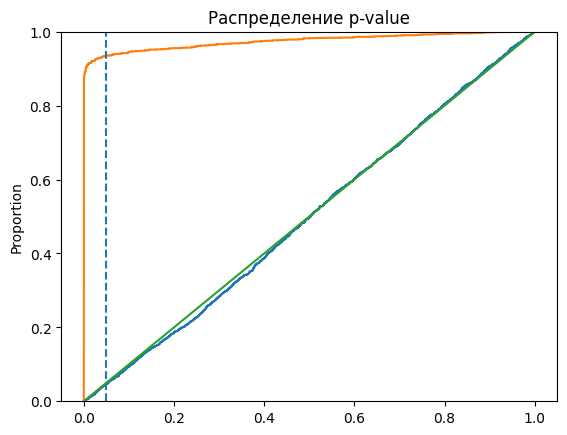

In [52]:
sns.ecdfplot(cuped_aa_test)
sns.ecdfplot(cuped_ab_test)
plt.vlines(x=0.05, ymin=0, ymax=1, linestyles='--')
plt.plot(x, x)
plt.title('Распределение p-value')
plt.show()

Такие показатели мощности и ожидаемой ошибки первого рода точно нас устроят. В зависимости от вносимого изменения и стоимости можем уменьшить размер выборки, которая потребуется для нашего теста, чтобы мощность критерия была равна 0.8.

На деле можем сократить выборку до 38-40 человек.

In [90]:
cuped_aa_test = []
cuped_ab_test = []
cuped_first_type_error = []
SAMPLE_SIZE = 38
EFFECT_SIZE = 100

for i in tqdm(range(2000)):
    df = dataframes[np.random.choice(length, size=1)[0]]

    control = df.sample(SAMPLE_SIZE * 2)
    
    experiment = control.iloc[:SAMPLE_SIZE, :]
    control = control.iloc[SAMPLE_SIZE:, :]
    control['treatment'] = 0
    experiment['treatment'] = 1
    df = pd.concat((control, experiment), axis=0)
    
    df['purchase_diff'] = df['sum_purchase_1'] - df['sum_purchase_0']

    mean_purchase_before = df['sum_purchase_0'].mean()

    beta = np.cov(df['sum_purchase_0'], df['purchase_diff'])[0, 1] / np.var(df['sum_purchase_0'])

    df['purchase_diff_cuped'] = df['purchase_diff'] - beta * (df['sum_purchase_0'] - mean_purchase_before)

    control_group_cuped = df[df['treatment'] == 0]['purchase_diff_cuped']
    treatment_group_cuped = df[df['treatment'] == 1]['purchase_diff_cuped']

    pval = stats.ttest_ind(treatment_group_cuped, control_group_cuped, equal_var=False).pvalue
    cuped_aa_test.append(pval)
    if pval < 0.05:
        cuped_first_type_error.append(1)
    else:
        cuped_first_type_error.append(0)

    pval = stats.ttest_ind(treatment_group_cuped+EFFECT_SIZE, control_group, equal_var=False).pvalue
    cuped_ab_test.append(pval)

cuped_ab_test = np.array(cuped_ab_test)

100%|██████████| 2000/2000 [00:32<00:00, 61.60it/s]


In [91]:
print('Ошибка первого рода:', round(np.array(cuped_first_type_error).mean(), 3))
print('Мощность критерия на 5-процентном уровне значимости:', np.round(cuped_ab_test[cuped_ab_test <= 0.05].shape[0] / cuped_ab_test.shape[0], 2))

Ошибка первого рода: 0.044
Мощность критерия на 5-процентном уровне значимости: 0.83


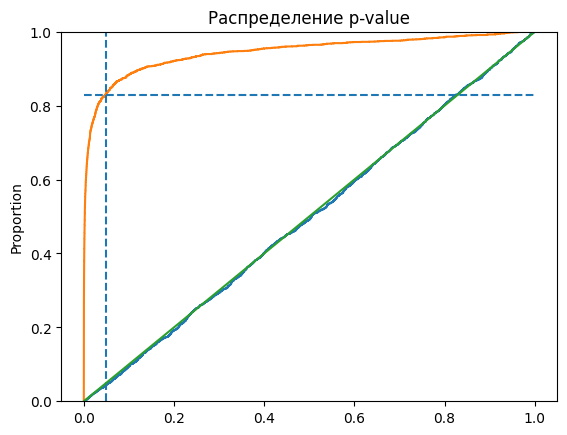

In [92]:
sns.ecdfplot(cuped_aa_test)
sns.ecdfplot(cuped_ab_test)
plt.vlines(x=0.05, ymin=0, ymax=1, linestyles='--')
plt.hlines(y=0.83, xmin=0, xmax=1, linestyles='--')
plt.plot(x, x)
plt.title('Распределение p-value')
plt.show()

Но что, если мы хотим обнаружить эффект не в размере 100 руб., а, учитывая разный достаток клиентов, будем ожидать процентный прирост. Для этого понадобится большая контрольная и экспериментальная выборки.

In [84]:
cuped_aa_test = []
cuped_ab_test = []
cuped_first_type_error = []
SAMPLE_SIZE = 100
EFFECT_SIZE = 0.01

for i in tqdm(range(2000)):
    df = dataframes[np.random.choice(length, size=1)[0]]

    control = df.sample(SAMPLE_SIZE * 2)
    
    experiment = control.iloc[:SAMPLE_SIZE, :]
    control = control.iloc[SAMPLE_SIZE:, :]
    control['treatment'] = 0
    experiment['treatment'] = 1
    df = pd.concat((control, experiment), axis=0)
    
    df['purchase_diff'] = df['sum_purchase_1'] - df['sum_purchase_0']

    mean_purchase_before = df['sum_purchase_0'].mean()

    beta = np.cov(df['sum_purchase_0'], df['purchase_diff'])[0, 1] / np.var(df['sum_purchase_0'])

    df['purchase_diff_cuped'] = df['purchase_diff'] - beta * (df['sum_purchase_0'] - mean_purchase_before)

    control_group_cuped = df[df['treatment'] == 0]['purchase_diff_cuped']
    treatment_group_cuped = df[df['treatment'] == 1]['purchase_diff_cuped']

    pval = stats.ttest_ind(treatment_group_cuped, control_group_cuped, equal_var=False).pvalue
    cuped_aa_test.append(pval)
    if pval < 0.05:
        cuped_first_type_error.append(1)
    else:
        cuped_first_type_error.append(0)

    # Изменяем эффект: теперь он выражен в процентном приросте, а не в количественном
    pval = stats.ttest_ind(treatment_group_cuped*(1+EFFECT_SIZE), control_group, equal_var=False).pvalue
    cuped_ab_test.append(pval)

cuped_ab_test = np.array(cuped_ab_test)

100%|██████████| 2000/2000 [00:30<00:00, 65.53it/s]


In [85]:
print('Ошибка первого рода:', round(np.array(cuped_first_type_error).mean(), 3))
print('Мощность критерия на 5-процентном уровне значимости:', np.round(cuped_ab_test[cuped_ab_test <= 0.05].shape[0] / cuped_ab_test.shape[0], 2))

Ошибка первого рода: 0.044
Мощность критерия на 5-процентном уровне значимости: 0.87


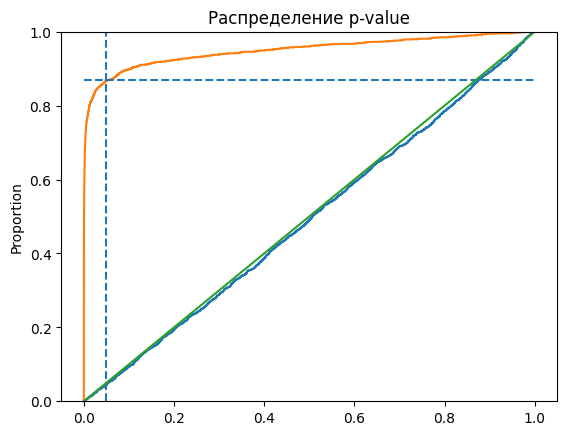

In [88]:
sns.ecdfplot(cuped_aa_test)
sns.ecdfplot(cuped_ab_test)
plt.vlines(x=0.05, ymin=0, ymax=1, linestyles='--')
plt.hlines(y=0.87, xmin=0, xmax=1, linestyles='--')
plt.plot(x, x)
plt.title('Распределение p-value')
plt.show()